# Hypothyroidism detector model

## Context:

Nairobi Hospital conducted a clinical camp to test for hypothyroidism. The data collected focused on Thyroid patients.

Hypothyroidism is a condition in which the thyroid gland is not able to produce enough thyroid hormone. Since the main purpose of thyroid hormone is to "run the body's metabolism," it is understandable that people with this condition will have symptoms associated with a slow metabolism. 

Hypothyroidism's deficiency of thyroid hormones can disrupt such things as heart rate, body temperature and all aspects of metabolism. Hypothyroidism is most prevalent in older women.

Major symptoms include fatigue, cold sensitivity, constipation, dry skin and unexplained weight gain.

Treatment consists of thyroid hormone replacement.

We are to build a model that determines whether or not the patient's symptoms indicate that the patient has hypothyroid.


#### Metric for success:
Our model should achieve a 75% to 80% accuracy rate to be viable as a first-stage analytics model. It can be refined further to improve accuracy. 


# Data Exploration

In [0]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import warnings

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [28]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# loading our dataset

url = 'http://bit.ly/hypothyroid_data'

hypothyroid_df = pd.read_csv(url)
hypothyroid_df.head(20)

,status,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,sick,tumor,lithium,goitre,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72,M,f,f,f,f,f,f,f,f,f,f,f,y,30,y,0.60,y,15,y,1.48,y,10,n,?
1,hypothyroid,15,F,t,f,f,f,f,f,f,f,f,f,f,y,145,y,1.70,y,19,y,1.13,y,17,n,?
2,hypothyroid,24,M,f,f,f,f,f,f,f,f,f,f,f,y,0,y,0.20,y,4,y,1,y,0,n,?
3,hypothyroid,24,F,f,f,f,f,f,f,f,f,f,f,f,y,430,y,0.40,y,6,y,1.04,y,6,n,?
4,hypothyroid,77,M,f,f,f,f,f,f,f,f,f,f,f,y,7.30,y,1.20,y,57,y,1.28,y,44,n,?
5,hypothyroid,85,F,f,f,f,f,t,f,f,f,f,f,f,y,138,y,1.10,y,27,y,1.19,y,23,n,?
6,hypothyroid,64,F,f,f,f,t,f,f,f,f,f,f,f,y,7.70,y,1.30,y,54,y,0.86,y,63,n,?
7,hypothyroid,72,F,f,f,f,f,f,f,f,f,f,f,f,y,21,y,1.90,y,34,y,1.05,y,32,n,?
8,hypothyroid,20,F,f,f,f,f,t,f,f,f,f,f,f,y,92,n,?,y,39,y,1.21,y,32,n,?
9,hypothyroid,42,F,f,f,f,f,f,f,f,f,f,f,f,y,48,n,?,y,7.60,y,1.02,y,7.50,n,?


I had to externally consult to find the meaning of the features used in this dataset. Here is a breakdown, along with an indication of what is better (a healthy patient), and what is worse (patient with /  succeptible to hypothroidism).

TSH = (Thyrotropin) thyroid stimulating hormone - lower is better, threshold = 5

T3 = Triiodothyronine - lower is better

TT4 = Thyroxide - lower is better

T4U = Triiodothyronine Utilization rate - higher is better

FTI = **Free Thyroxine Index** - The FTI is obtained by multiplying the (Total T4) times (T3 Uptake) to obtain an index. The FTI is considered a more reliable indicator of thyroid status in the presence of abnormalities in plasma protein binding. It is elevated in hyperthyroidism and depressed in hypothyroidism.

TBG = **Thyroxine-binding globulin** - TBG binds thyroid hormones in circulation. It is one of three transport proteins responsible for carrying the thyroid hormones thyroxine and triiodothyronine in the bloodstream. - higher is better

In [4]:
hypothyroid_df.shape

(3163, 26)

26 columns represent a very high dimensionality for our dataset. This may bring unnecesssary complexity. 

Some of the columns will get eliminated, for example, those asking whether or not a certain hormone was tested in the patient. Those columns help explain the null values, e.g. if you have a "no" for a certain test, then you won't have a figure recorded in the next column.

Another thing I'd like to know off the bat is the number of null values, and dimensionality for each categorical column.



In [5]:
# Checking dimensionality of the columns

hypothyroid_df.describe().T

,count,unique,top,freq
status,3163,2,negative,3012
age,3163,93,?,446
sex,3163,3,F,2182
on_thyroxine,3163,2,f,2702
query_on_thyroxine,3163,2,f,3108
on_antithyroid_medication,3163,2,f,3121
thyroid_surgery,3163,2,f,3059
query_hypothyroid,3163,2,f,2922
query_hyperthyroid,3163,2,f,2920
pregnant,3163,2,f,3100


In the case of the categorical columns with 2 unique values, we can further analyse what these 2 unique entries are, and how frequently each appears.

In [6]:
# Checking for null values

hypothyroid_df.isnull().any()

status                       False
age                          False
sex                          False
on_thyroxine                 False
query_on_thyroxine           False
on_antithyroid_medication    False
thyroid_surgery              False
query_hypothyroid            False
query_hyperthyroid           False
pregnant                     False
sick                         False
tumor                        False
lithium                      False
goitre                       False
TSH_measured                 False
TSH                          False
T3_measured                  False
T3                           False
TT4_measured                 False
TT4                          False
T4U_measured                 False
T4U                          False
FTI_measured                 False
FTI                          False
TBG_measured                 False
TBG                          False
dtype: bool

There are no null values in our dataset.

In [7]:
# Check for duplicate rows

duplicates = hypothyroid_df[hypothyroid_df.duplicated()]
duplicates.shape

(77, 26)

< 3% of our rows are duplicates. I have no qualms about dropping them.

In [0]:
# Drop duplicate rows

hypothyroid_df2 = hypothyroid_df
hypothyroid_df = hypothyroid_df.drop_duplicates()

In [9]:
# Confirming the the duplicate rows have been dropped

hypothyroid_df.shape

(3086, 26)

In [10]:
# Data types for each of the features

hypothyroid_df.dtypes

status                       object
age                          object
sex                          object
on_thyroxine                 object
query_on_thyroxine           object
on_antithyroid_medication    object
thyroid_surgery              object
query_hypothyroid            object
query_hyperthyroid           object
pregnant                     object
sick                         object
tumor                        object
lithium                      object
goitre                       object
TSH_measured                 object
TSH                          object
T3_measured                  object
T3                           object
TT4_measured                 object
TT4                          object
T4U_measured                 object
T4U                          object
FTI_measured                 object
FTI                          object
TBG_measured                 object
TBG                          object
dtype: object

Object data types are a mix of strings and numbers. We will need to change the data types for some of the columns later. The variables that will help us with our modeling. 

# EDA

In [11]:
# Pandas Profiling

import pandas_profiling

pandas_profiling.ProfileReport(hypothyroid_df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,27
Number of observations,3086
Total Missing (%),0.0%
Total size in memory,651.1 KiB
Average record size in memory,216.0 B
Numeric,1
Categorical,26
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Pandas Profiling has revealed a problem I failed to take care of earlier, since I hadn't seen rows with the entry "?" except for the last column.

If these columns are filled in the right way, we can use imputation techniques to fill them in. That way, the rows aren't completely useless. There's to many to drop anyway (400 for some featuress 600+ for others) so this is the most pragmatic course of action to pursue.

Some more key takeaways:


1.   Most (69%) of the participants were female. 
1.   The minority (4.6%) of the participants tested positive for hypothyroidism. This was also refelcted in the metrics for antithyroid medication and surgery i.e. if you don't have hypothyroidism, you don't need medication for it, and your thyroid glands are fine so it's also highly likely that you never needed surgery to rectify a problem in that area.

1.   Most (97%) of the respondents were not sick at the time of the study.

1.   Only 2% of the respondents were pregnant at the time of the study.
2.   We had more than 95% of the respondents test  negative for goitre and tumors at the time of the study. These are precursors of hypothyroidism, so this data reflects the overwhelmingly negative results we have when the respondents were tested for hypothyroidism.






In [12]:
# Repalacing ?'s with Null values (nan's)

hypothyroid_df = hypothyroid_df.replace(['?'], np.nan)

# Confirmation

hypothyroid_df.isnull().sum()

status                          0
age                           438
sex                            73
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
thyroid_surgery                 0
query_hypothyroid               0
query_hyperthyroid              0
pregnant                        0
sick                            0
tumor                           0
lithium                         0
goitre                          0
TSH_measured                    0
TSH                           455
T3_measured                     0
T3                            680
TT4_measured                    0
TT4                           240
T4U_measured                    0
T4U                           239
FTI_measured                    0
FTI                           238
TBG_measured                    0
TBG                          2835
dtype: int64

In [0]:
# Creating another backup, as we go along

hypothyroid_df3 = hypothyroid_df

In [0]:
# Here we will replace all the numerical column nan's with their median values

from sklearn.impute import SimpleImputer

numericols = ['FTI','T3','T4U','TBG','TSH','TT4']

imputer = SimpleImputer(strategy = 'median')

hypothyroid_df[numericols] = imputer.fit_transform(hypothyroid_df[numericols])

In [0]:
# The same can be done with categorical columns. The recommended course of action is to replace missing values with the mode for each of those columns

strings = ['status','sex','on_thyroxine','query_on_thyroxine','FTI_measured','lithium','on_antithyroid_medication',
            'pregnant','query_hypothyroid','query_hyperthyroid','sick','T3_measured','T4U_measured','TBG_measured',
            'thyroid_surgery','TSH_measured','TT4_measured','tumor']

imputer2 = SimpleImputer(strategy='most_frequent')

hypothyroid_df[strings] = imputer2.fit_transform(hypothyroid_df[strings])


For the age column, I'm choosing to replace the missing values with the mean age over median. This is because patients at risk for hypothyroidism tend clustered around a certain bracket representing an older demographic. Thus, the mean would be appropriate to use in this case.



In [0]:


agecols = ['age']

imputer = SimpleImputer(strategy = 'mean')

hypothyroid_df[agecols] = imputer.fit_transform(hypothyroid_df[agecols])


In [17]:
# Confirmation, we should have eliminated the null values now:

hypothyroid_df.isnull().sum()

status                       0
age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
thyroid_surgery              0
query_hypothyroid            0
query_hyperthyroid           0
pregnant                     0
sick                         0
tumor                        0
lithium                      0
goitre                       0
TSH_measured                 0
TSH                          0
T3_measured                  0
T3                           0
TT4_measured                 0
TT4                          0
T4U_measured                 0
T4U                          0
FTI_measured                 0
FTI                          0
TBG_measured                 0
TBG                          0
dtype: int64

## Detecting outliers

IN the box plots below, outliers are indicated by dots outside the lines (whiskers) extending from the main box plot. We'll use a for loop to iterate through the numerical columns defined in the impute cell.

In [0]:
fig, axes = plt.subplots(3,2, figsize = (20, 20))

fig.suptitle('Box plots for different hormone tests', y= 1, color = 'black', fontsize = 20)

sns.set(style = 'whitegrid', context = 'notebook')


for ax, data, name in zip(axes.flatten(), hypothyroid_df, numericols):
    sns.boxplot( hypothyroid_df [name], ax = ax)
    ax.set_title('Box plot for '+ name)
  
plt.show()

I've raised this issue before, where matplotlib seems to not work veer since the new version came out. My charts consistently do not show. In the next cell I'll attempt to downgrade the version installed, and then try to run the box plots code again.

In [19]:
!pip install matplotlib==3.1.0

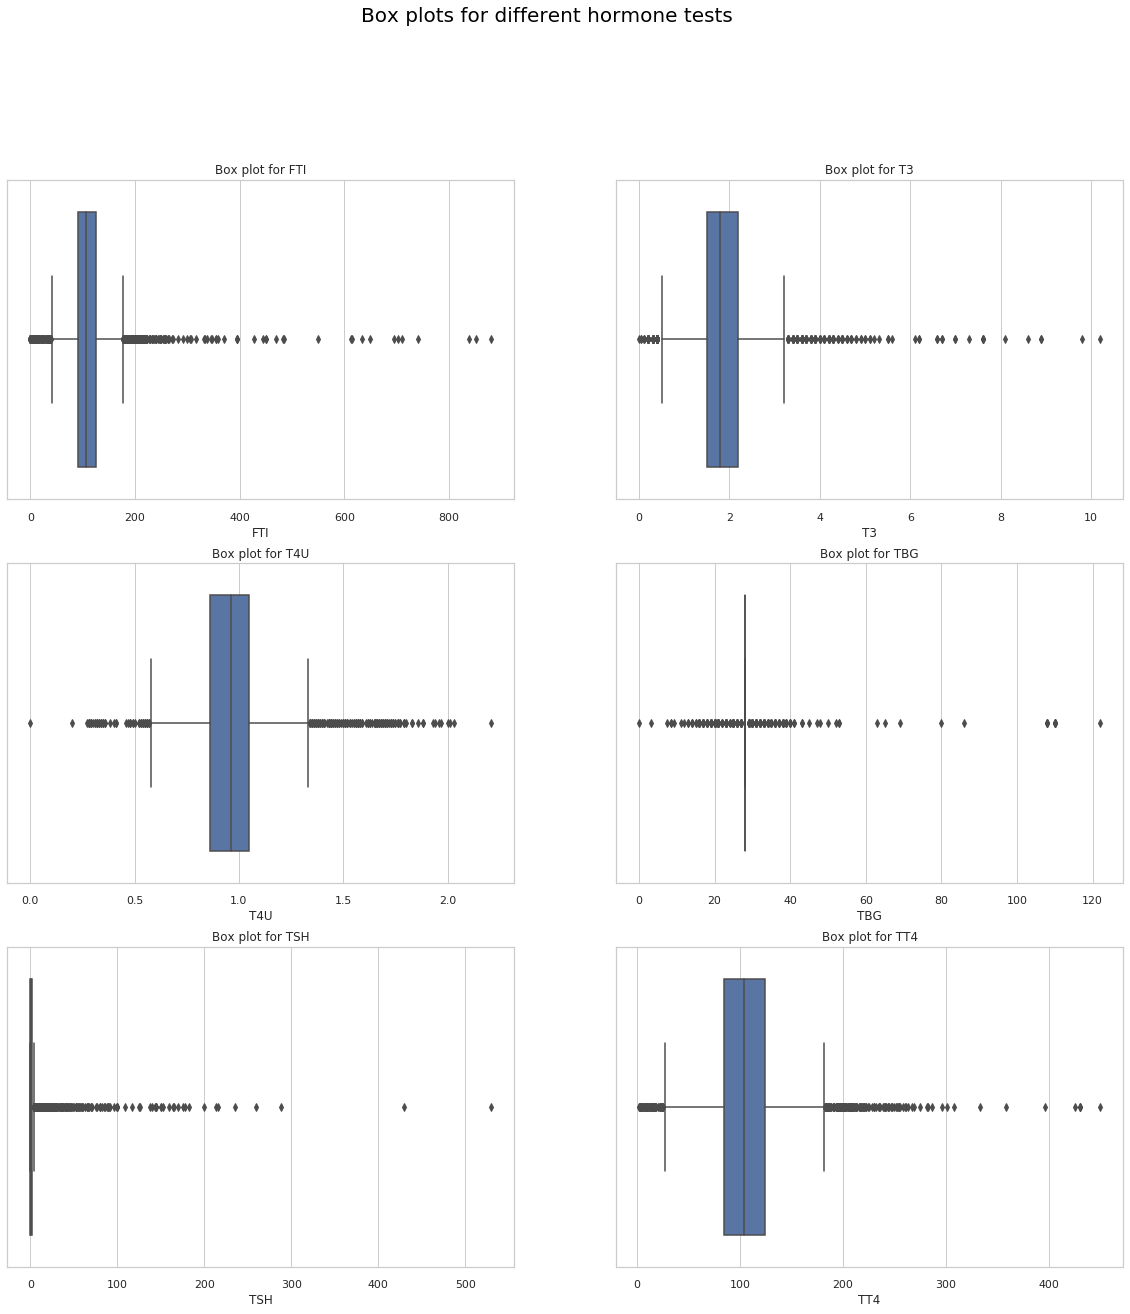

In [29]:
fig, axes = plt.subplots(3,2, figsize = (20, 20))

fig.suptitle('Box plots for different hormone tests', y= 1, color = 'black', fontsize = 20)

sns.set(style = 'whitegrid', context = 'notebook')


for ax, data, name in zip(axes.flatten(), hypothyroid_df, numericols):
    sns.boxplot( hypothyroid_df [name], ax = ax)
    ax.set_title('Box plot for '+ name)
plt.show()

Now it woeks. In addition to downgrading matplotlib, I added the following lines to my import section:

%matplotib inline
%pylab inline

## Correlation check



In [32]:
corr = hypothyroid_df.corr()
print ('Correlation matrix')
print ('....')
print(corr)

Correlation matrix
....
Empty DataFrame
Columns: []
Index: []


After researching, I've seen that the correlation matrix is empty due to our dataset's data types. As was forshadowed before, We now have to coonvert the .object data types to string, for the numerical columns. 

In [34]:
def create_null(X, columns):
  for i in columns:
    X[i] = pd.to_numeric(X[i], errors='coerce')
    
# Our array of numerical columns comes into play once again
numericols2 = ['FTI','T3','T4U','TBG','TSH','TT4', 'age']
create_null(hypothyroid_df, numericols)
hypothyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3086 entries, 0 to 3162
Data columns (total 26 columns):
status                       3086 non-null object
age                          3086 non-null object
sex                          3086 non-null object
on_thyroxine                 3086 non-null object
query_on_thyroxine           3086 non-null object
on_antithyroid_medication    3086 non-null object
thyroid_surgery              3086 non-null object
query_hypothyroid            3086 non-null object
query_hyperthyroid           3086 non-null object
pregnant                     3086 non-null object
sick                         3086 non-null object
tumor                        3086 non-null object
lithium                      3086 non-null object
goitre                       3086 non-null object
TSH_measured                 3086 non-null object
TSH                          3086 non-null float64
T3_measured                  3086 non-null object
T3                           3086 non-null

As seen in the output above, our numerical columns arenow utilising the float data type, like the good Lord intended.

Our correlation matrix should be able to display this time:

In [35]:
corr = hypothyroid_df.corr()
print ('Correlation matrix')
print ('....')
print(corr)

Correlation matrix
....
          TSH        T3       TT4       T4U       FTI       TBG
TSH  1.000000 -0.168365 -0.307814  0.074268 -0.239845 -0.008356
T3  -0.168365  1.000000  0.529258  0.384988  0.279011  0.015203
TT4 -0.307814  0.529258  1.000000  0.320807  0.677725  0.022698
T4U  0.074268  0.384988  0.320807  1.000000 -0.293274  0.024589
FTI -0.239845  0.279011  0.677725 -0.293274  1.000000 -0.005188
TBG -0.008356  0.015203  0.022698  0.024589 -0.005188  1.000000


Apart from TT4 and FTI, None of the columns are highly correlated. Just for context, the numbers range from -1 to 1, with 1 being highly (positively) correlated. That means that an increase in one of the columns from the pair is matched by an increase in value in the other column as well.

A heatmap displaying the same would be easier to interpret, but as stated before, I'm having problems with my matplotlib installation.

# Modeling

First order of business is to encode the categorical columns we will be using for our models.

In [36]:
# Quick backup
hypothyroid_df4 = hypothyroid_df

# Import label encoder 
from sklearn import preprocessing 
  

label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in the status column 
hypothyroid_df['status']= label_encoder.fit_transform(hypothyroid_df['status']) 
  
hypothyroid_df['status'].unique()

array([0, 1])

In [37]:
hypothyroid_df['status'].value_counts()

1    2945
0     141
Name: status, dtype: int64

0 represents patients with hypothyroidism, and 1 represents the opposite

Since we're checking for hypothyroidism, our label is 'Status' i.e. our model's output should indicate if a patient has hypothyroidism (0) or not (1) 

In [0]:
from sklearn.model_selection import train_test_split

# Setting labels and features

y = hypothyroid_df['status'].values


test_features = hypothyroid_df.columns.to_list()
test_features.remove('status')

# We should be able to use nearly all the other features, but for the sake of simplifying our visualization later, we only pick a few.
x = hypothyroid_df[test_features]

#Feature engineering.
x = pd.get_dummies(x)
X = x.values

## Random Forest

In [0]:
# Train using 70% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Import the model
from sklearn.ensemble import RandomForestClassifier




In [45]:
forest = RandomForestClassifier(n_estimators = 200, random_state=42, min_samples_split=10, max_depth=15)

forest = forest.fit(X_train, y_train)

ypred = forest.predict(X_test)

f1_score(y_test, y_pred)

0.9927170868347338

Our Random Forest model's accuracy is 99%. This is great!

In [46]:
comparison_frame = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

comparison_frame.head()

,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [48]:
# We can assess the model's degree of inaccuracy

from sklearn import metrics


print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.014038876889848811
Mean Squared Error: 0.014038876889848811
Root Mean Squared Error: 0.1184857666129093


These very low numbers bode well for our model, remember, they're tests for INACCURACY.

This is reflected in our accuracy score (99%) above

In [49]:
tree = forest.estimators_[20]
importances = list(tree.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x.columns, importances)]                   
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

                   
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TSH                  Importance: 0.61
Variable: FTI                  Importance: 0.2
Variable: TT4                  Importance: 0.14
Variable: T3                   Importance: 0.01
Variable: age_27.0             Importance: 0.01
Variable: on_thyroxine_t       Importance: 0.01
Variable: TSH_measured_y       Importance: 0.01
Variable: T4U                  Importance: 0.0
Variable: TBG                  Importance: 0.0
Variable: age_1.0              Importance: 0.0
Variable: age_4.0              Importance: 0.0
Variable: age_5.0              Importance: 0.0
Variable: age_6.0              Importance: 0.0
Variable: age_7.0              Importance: 0.0
Variable: age_8.0              Importance: 0.0
Variable: age_9.0              Importance: 0.0
Variable: age_10.0             Importance: 0.0
Variable: age_11.0             Importance: 0.0
Variable: age_12.0             Importance: 0.0
Variable: age_13.0             Importance: 0.0
Variable: age_14.0             Importance: 0.0
Variabl

The results above show that the most important indicators for hypothyroidism are TT4, FTI and TSH.

I would have plotted the same but I am having issues with Seaborn.

### Gradient Boosting

In [0]:
gbc = GradientBoostingClassifier(n_estimators= 80, learning_rate=0.01, max_depth=3, min_samples_split=10)

In [51]:
gbc = gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)

f1_score(y_test, y_pred_gbc)

0.9977477477477478

Our Gradient Boosting classifier has improved accuracy scores from 99.271% to 99.774%

In [54]:

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=250)
                         

abc = abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

f1_score(y_test, y_pred)

0.9954853273137698

Our Ada Boost classifier has an accuracy score of 99.548%

This is also a slight improvement from our initial Random Forest Classifier.

# Support Vector Machine

In [58]:
svc = SVC(kernel = 'linear',  C = 1, gamma = 0.001)

svc = svc.fit(X_train, y_train)


y_pred = svc.predict(X_test)

f1_score(y_test, y_pred)

0.9954853273137698

In [59]:
svc = SVC(kernel = 'poly',  C = 1, gamma = 0.001)

svc = svc.fit(X_train, y_train)


y_pred = svc.predict(X_test)

f1_score(y_test, y_pred)

0.9955005624296963

In [60]:
svc = SVC(kernel = 'rbf',  C = 4, gamma = 0.001)

svc = svc.fit(X_train, y_train)


y_pred = svc.predict(X_test)

f1_score(y_test, y_pred)

0.9943820224719102

The polynomial model gives us the highest accuracy of the three, although it's also important to note that all three scores are within 0.1% of eachother. 